In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import shuffle
import utils
import shutil
import pickle
import custom_model
import glob
import pandas as pd
import numpy as np
import itertools, os
from tqdm import tqdm
from scipy.stats import pearsonr

2023-12-18 07:54:38.514601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cell_lines = [4824, 5110, 5111]
cell_line_names = ['PC-3', 'GM12878', 'K562']
bin_index = [447, 448]
model_name = 'enformer'
pdf_dir = utils.make_dir('pdf_dir')

threshold_enh, threshold_neu, threshold_sil = 0.95, 0.05, -0.3

In [3]:
seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')
model = custom_model.Enformer()

2023-12-18 07:54:46.831657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 07:54:47.218577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 66895 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [11]:
pd.read_csv('../results/gencode_tss_predictions/enformer/4824_PC-3_selected_tss.csv').shape



(10000, 7)

In [12]:
res = []
for i, c in enumerate(cell_lines):
    selected_tss_path = glob.glob(f'../results/gencode_tss_predictions/{model_name}/*{c}*_selected_tss.csv')[0]
    cell_name = selected_tss_path.split('_')[-3]
    delta_means = []
    mut_means = []
    wt_means = []
    mut_stds = []
    paths = []
    print(cell_name)
    selected_tss = pd.read_csv(selected_tss_path)
    for _, row in selected_tss.iterrows():
        
        r = f'../results/context_dependence_test_100/{model_name}/{utils.get_summary(row)}.pickle'
        with open(r, 'rb') as handle:
            context_res = pickle.load(handle)
        delta = creme.context_effect_on_tss(context_res['wt'][bin_index,i].mean(), context_res['mut'][bin_index,i].mean())
        delta_means.append(delta)
        wt_means.append(context_res['wt'][bin_index,i].mean())
        mut_stds.append(context_res['std'][bin_index,i].mean())
        mut_means.append(context_res['mut'][bin_index, i].mean())
        paths.append(r)
        
    df = pd.DataFrame([delta_means, paths]).T
    df.columns = ['delta mean', 'path']
    df['wt'] = wt_means
    # df = df[df['delta std'] < np.quantile(df['delta std'], 0.99)]
    df['std'] = mut_stds
    df['std/mean'] = np.array(mut_stds) / wt_means
    df['mean_mut'] = mut_means
    df['context'] = [v for v in pd.cut(df['delta mean'], 
                                       [df['delta mean'].min()-1, threshold_sil, -threshold_neu, threshold_neu, threshold_enh, df['delta mean'].max()+1], 
                           labels=['silencing', 'other1', 'neutral', 'other', 'enhancing']).values]
    df['cell line'] = cell_name
    n_quantiles = 3
    df['std_strata'] = [v for v in pd.cut(df['std/mean'], 
                                   [np.quantile(df['std/mean'], i) for i in [0, 0.25, 0.5, 0.75, 1]], 
                       labels=['<0.25', '0.25-0.5', '0.5-0.75', '>0.75'])]

    
    print(df.shape)
    res.append(df)

res = pd.concat(res).reset_index(drop=True)
    

PC-3
(10000, 9)
GM12878
(10000, 9)
K562
(10000, 9)


In [100]:
subsample = []
for (cell_line, std_strata), df in res.groupby(['cell line', 'std_strata']):
    np.random.seed(42)
    subsample.append(df.sample(frac=0.01))
subsample = pd.concat(subsample)

In [101]:
subsample.to_csv('../results/subsample.csv')

In [6]:
lower_bounds = res['mean_mut'] - res['std'] * 2
upper_bounds = res['mean_mut'] + res['std'] * 2

std_based_labels = []
for i, row in res.iterrows():
    if row['wt'] < lower_bounds[i] and row['delta mean'] < threshold_sil:
        std_based_labels.append('silencing')
    elif row['wt'] > upper_bounds[i] and row['delta mean'] > threshold_enh:
        std_based_labels.append('enhancing')
    elif np.abs(row['delta mean']) < threshold_neu and (row['wt'] > lower_bounds[i] and row['wt']<upper_bounds[i]):
        std_based_labels.append('neutral')
    else:
        std_based_labels.append('other')
res['std_based_class'] = std_based_labels

In [58]:
res.to_csv(f'../results/context_dependence_test/{model_name}_result_summary.csv')

In [72]:
bins = [447, 448]
cell_index = 5111

In [84]:
res[res['cell line']=='PC-3']

,delta mean,path,wt,std,std/mean,mean_mut,context,cell line,std_strata
0,0.510139,../results/context_dependence_test/enformer/XP...,14.783686,1.378518,0.093246,7.241948,other,PC-3,NaN
1,0.939964,../results/context_dependence_test/enformer/UP...,14.785568,0.474415,0.032086,0.887662,other,PC-3,0.2
2,0.874547,../results/context_dependence_test/enformer/PL...,14.797552,0.714717,0.048300,1.856394,other,PC-3,NaN
3,-0.996532,../results/context_dependence_test/enformer/ZN...,14.800878,4.700536,0.317585,29.550421,silencing,PC-3,NaN
4,0.847226,../results/context_dependence_test/enformer/SL...,14.805020,0.834765,0.056384,2.261822,other,PC-3,NaN
...,...,...,...,...,...,...,...,...,...
9995,0.672157,../results/context_dependence_test/enformer/CC...,447.296265,36.326038,0.081212,146.643143,other,PC-3,NaN
9996,0.704326,../results/context_dependence_test/enformer/MD...,449.297974,23.068985,0.051345,132.845551,other,PC-3,NaN
9997,0.576422,../results/context_dependence_test/enformer/HS...,451.603577,15.833138,0.035060,191.289307,other,PC-3,0.2
9998,0.553474,../results/context_dependence_test/enformer/IT...,454.687561,18.712582,0.041155,203.029587,other,PC-3,NaN


In [78]:
for i, row in tqdm(res.iterrows()):
    chrom, start, strand = row['path'].split('/')[-1].split('_')[1:4]
    start = int(start)
    strand = strand.split('.')[0]
    seq = seq_parser.extract_seq_centered(chrom, start, strand, model.seq_length)
    mutants = {}
    for sample_size in range(10, 101, 10):
        mutants[sample_size] = []
        print(sample_size)
        for _ in range(sample_size):
            x_mut = shuffle.dinuc_shuffle(seq)
            x_mut[(model.seq_length - 5000) // 2:(model.seq_length + 5000) // 2] = seq[
                                                                                   (model.seq_length - 5000) // 2:(model.seq_length + 5000) // 2].copy()
            pred_mut = model.predict(x_mut)[0, bins, cell_index].mean()

            mutants[sample_size].append(pred_mut)
        mutants[sample_size] = np.array(mutants[sample_size])
    break

0it [00:00, ?it/s]

10
20
30
40
50
60
70
80
90
100


0it [03:12, ?it/s]


In [81]:
{k:((v-row['wt'])/row['wt']).mean() for k, v in mutants.items()}

{10: 2.1163971,
 20: 2.3326526,
 30: 2.2694273,
 40: 2.3048897,
 50: 2.2309933,
 60: 2.0655243,
 70: 2.508466,
 80: 2.4509258,
 90: 2.1495924,
 100: 2.4685397}

In [56]:
model.predict(x_mut)[0, [447, 448],5111]

array([141.87576, 274.5106 ], dtype=float32)

In [59]:
subset_preds = utils.read_pickle('../results/sample_size_enformer_K562.pickle')

In [68]:
len(subset_preds[0.1]['preds'])

100

In [63]:
res

,delta mean,path,wt,std,std/mean,mean_mut,context,cell line,std_strata
0,0.510139,../results/context_dependence_test/enformer/XP...,14.783686,1.378518,0.093246,7.241948,other,PC-3,NaN
1,0.939964,../results/context_dependence_test/enformer/UP...,14.785568,0.474415,0.032086,0.887662,other,PC-3,0.2
2,0.874547,../results/context_dependence_test/enformer/PL...,14.797552,0.714717,0.048300,1.856394,other,PC-3,NaN
3,-0.996532,../results/context_dependence_test/enformer/ZN...,14.800878,4.700536,0.317585,29.550421,silencing,PC-3,NaN
4,0.847226,../results/context_dependence_test/enformer/SL...,14.805020,0.834765,0.056384,2.261822,other,PC-3,NaN
...,...,...,...,...,...,...,...,...,...
29995,0.358122,../results/context_dependence_test/enformer/EI...,536.997925,18.192219,0.033878,344.686920,other,K562,0.2
29996,0.498211,../results/context_dependence_test/enformer/ND...,543.358582,23.888557,0.043965,272.651428,other,K562,0.2
29997,0.432902,../results/context_dependence_test/enformer/SN...,546.634521,23.056347,0.042179,309.995605,other,K562,0.2
29998,0.13842,../results/context_dependence_test/enformer/RP...,550.108521,17.454762,0.031730,473.962341,other,K562,0.1


In [ ]:
subset_preds['0.9']['context_effect']

In [44]:
quantile_subset[j][:(i+1)*10].shape

(100,)

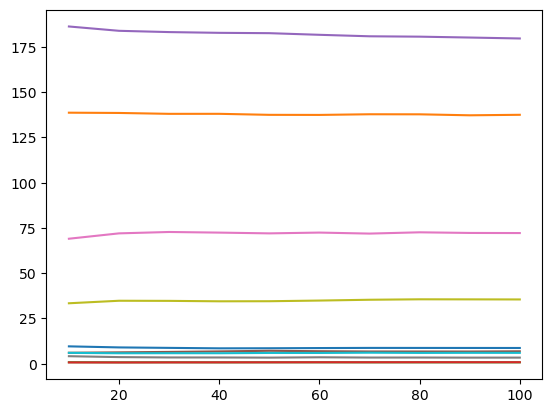

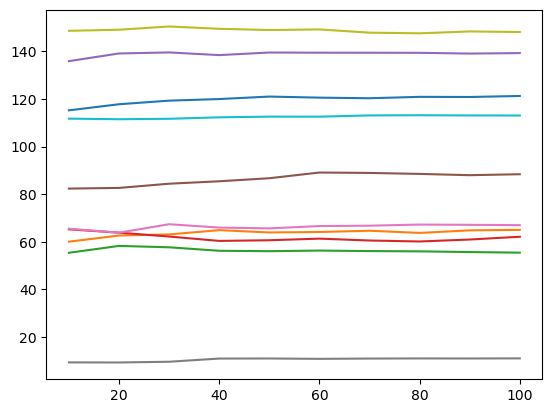

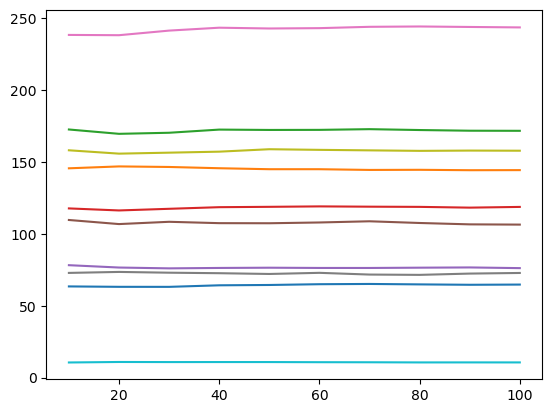

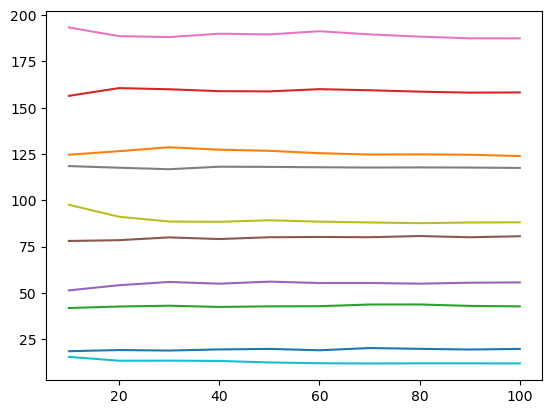

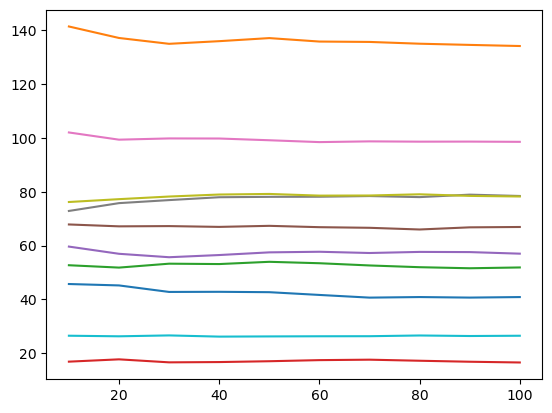

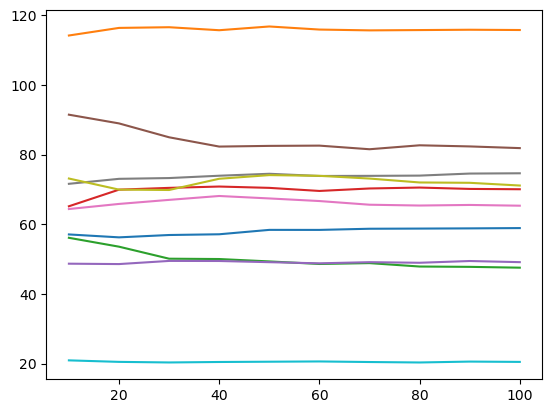

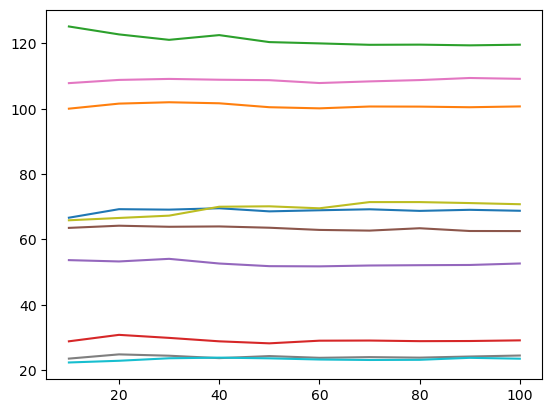

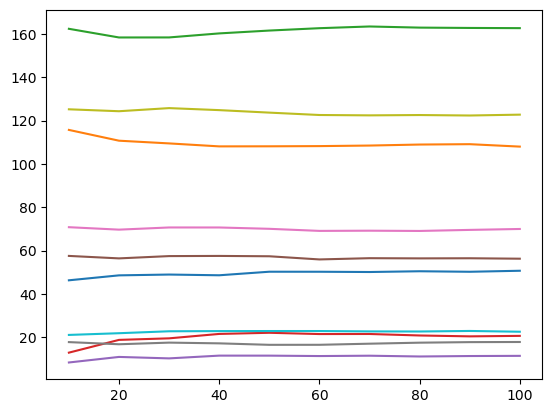

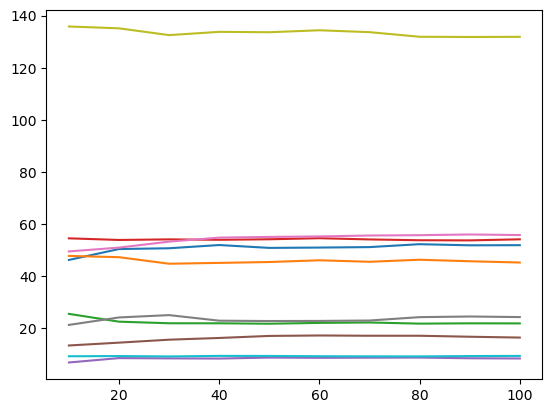

In [45]:
for k in subset_preds.keys():
    quantile_subset = subset_preds[k]['preds']
    N_seqs = len(quantile_subset)
    std_summary = np.empty((N_seqs, 10))
    for j in range(N_seqs):
        for i in range(10): 
            std_summary[j, i] = quantile_subset[j][:(i+1)*10].mean()
        sns.lineplot(x=list(range(10, 101, 10)), y=std_summary[j])
    plt.show()

<Axes: >

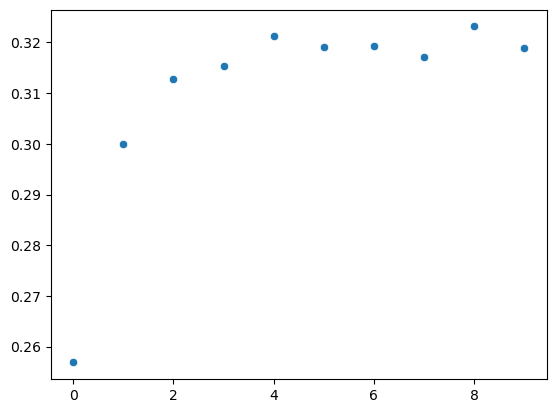

In [30]:
quantile_subset[j][:i*10].shape

(90,)

In [166]:
res[res['path']=='../results/context_dependence_test/enformer/ZIM2_chr19_56840726_-.pickle']

,delta mean,path,wt,std,mean_mut,context,cell line,std_based_class
1122,0.41538,../results/context_dependence_test/enformer/ZI...,22.315039,2.437686,13.045819,other,PC-3,other
11756,0.606071,../results/context_dependence_test/enformer/ZI...,103.205215,12.453520,40.655510,other,GM12878,other
21051,-0.334945,../results/context_dependence_test/enformer/ZI...,28.497692,14.873940,38.042850,silencing,K562,other


In [152]:
bad_row = res[(res['context']=='silencing') & (res['std_based_class']=='other') & (res['cell line']=='K562')].sort_values('std').iloc[-1]
bad_case = utils.read_pickle(bad_row['path'])
bad_row

delta mean                                                 -0.549663
path               ../results/context_dependence_test/enformer/ZN...
wt                                                          60.86187
std                                                        43.405994
mean_mut                                                   94.315376
context                                                    silencing
cell line                                                       K562
std_based_class                                                other
Name: 22699, dtype: object

In [153]:
chrom, start, strand = bad_row['path'].split('/')[-1].split('_')[1:4]
start = int(start)
strand = strand.split('.')[0]

In [154]:
bad_seq = seq_parser.extract_seq_centered(chrom, start, strand, model.seq_length)

In [155]:
mutants = []
for _ in tqdm(range(100)):
    x_mut = shuffle.dinuc_shuffle(bad_seq)
    x_mut[(model.seq_length-5000)//2:(model.seq_length+5000)//2] = bad_seq[(model.seq_length-5000)//2:(model.seq_length+5000)//2].copy()
    mutants.append(model.predict(x_mut)[0,446:449,5111].mean())
mutants = np.array(mutants)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


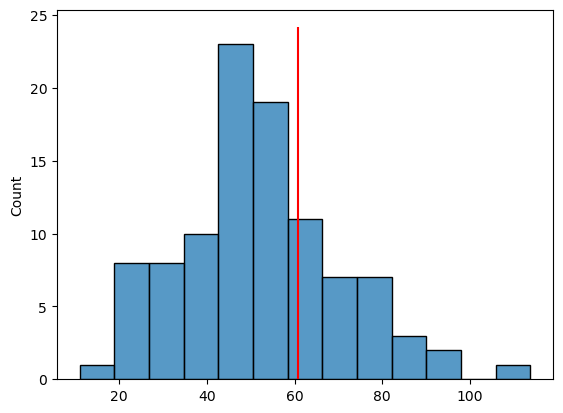

In [156]:
ax=sns.histplot(mutants)
y1, y2 = ax.get_ylim()
plt.vlines(bad_row['wt'], y1, y2, color='r')

In [167]:
np.std(mutants)

18.458282

18.040085
13.0290785
7.8720818
26.359232
16.331608
16.579683
19.94706
12.045477
16.78907
12.899156


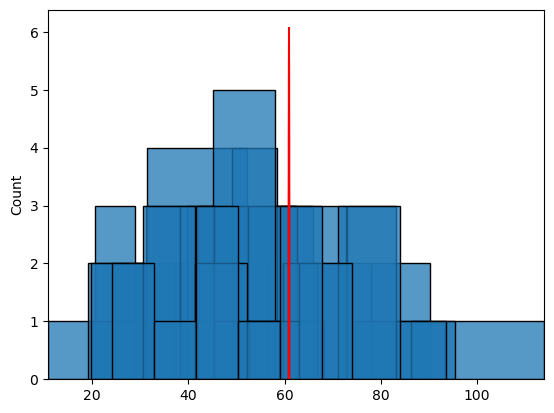

In [169]:
wt = bad_row['wt']
for i in range(0, 100, 10):
    m = mutants[i:i+10]
    ax=sns.histplot(m)
    y1, y2 = ax.get_ylim()
    plt.vlines(wt, y1, y2, color='r')
    plt.xlim(min(mutants), max(mutants))
    # plt.title(((m - wt) / wt).mean())
    print(np.std(m))
    # plt.show()

In [147]:
((bad_row['wt'] - mutants) / bad_row['wt']).mean()

-0.35365632

In [104]:
mutants

array([11.612114, 17.572334, 24.239594, 25.716614, 15.409028, 11.15084 ,
        8.227235, 27.491106, 19.47561 ,  8.379415], dtype=float32)

In [103]:
bad_row

delta mean                                                 -1.012924
path               ../results/context_dependence_test/enformer/AD...
wt                                                         13.951459
std                                                        17.955566
mean_mut                                                   28.083221
context                                                    silencing
cell line                                                       K562
std_based_class                                                other
Name: 20062, dtype: object

In [126]:
res_3_contexts = res[[True  if r in ['enhancing', 'neutral', 'silencing'] else False for r in res['context']]]
res_3_contexts.groupby(['cell line', 'context', 'std_based_class']).count()

delta mean  path   wt  std  mean_mut
cell line context   std_based_class                                      
GM12878   enhancing enhancing               423   423  423  423       423
          neutral   neutral                 190   190  190  190       190
                    other                     1     1    1    1         1
          silencing other                    29    29   29   29        29
                    silencing                49    49   49   49        49
K562      enhancing enhancing               507   507  507  507       507
          neutral   neutral                 284   284  284  284       284
                    other                     1     1    1    1         1
          silencing other                   157   157  157  157       157
                    silencing               166   166  166  166       166
PC-3      enhancing enhancing               539   539  539  539       539
          neutral   neutral                 104   104  104  104       104
                    other                     1     1    1    1         1
          silencing other                    29    29   29   29        29
                    silencing                64    64   64   64        64

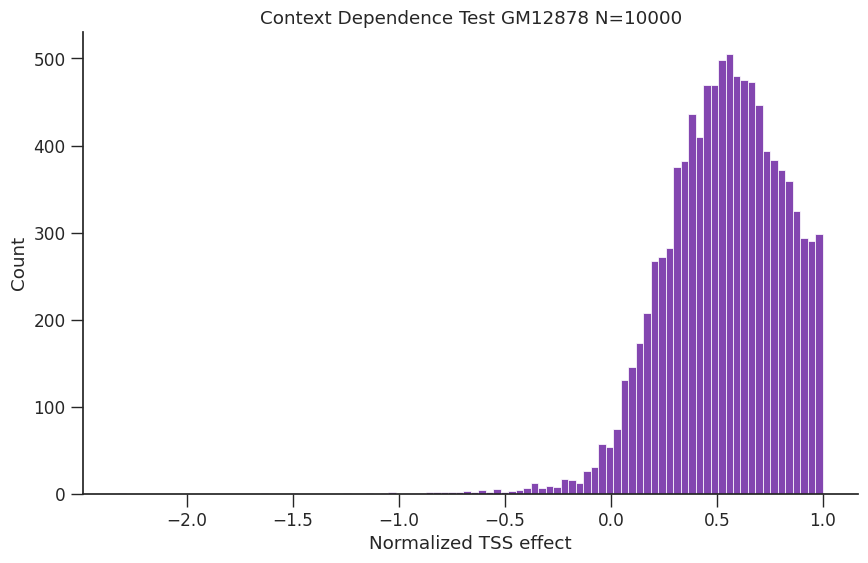

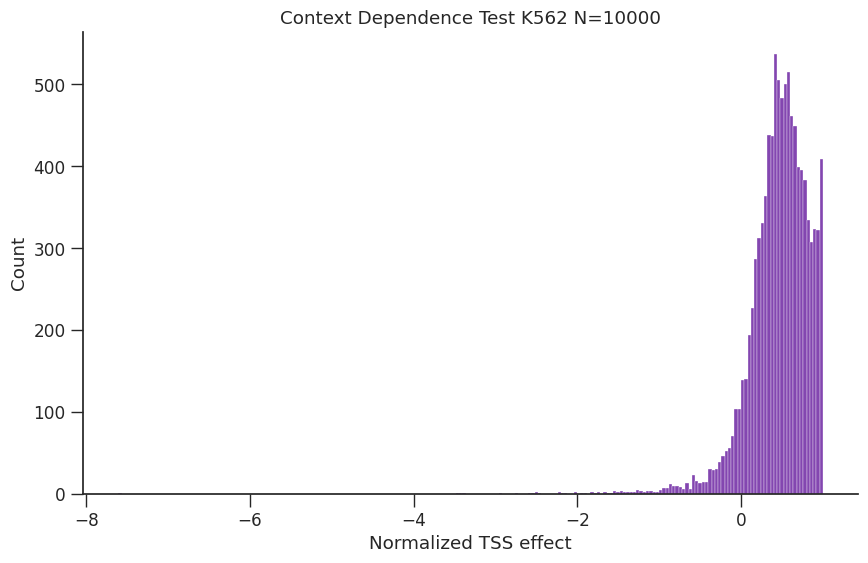

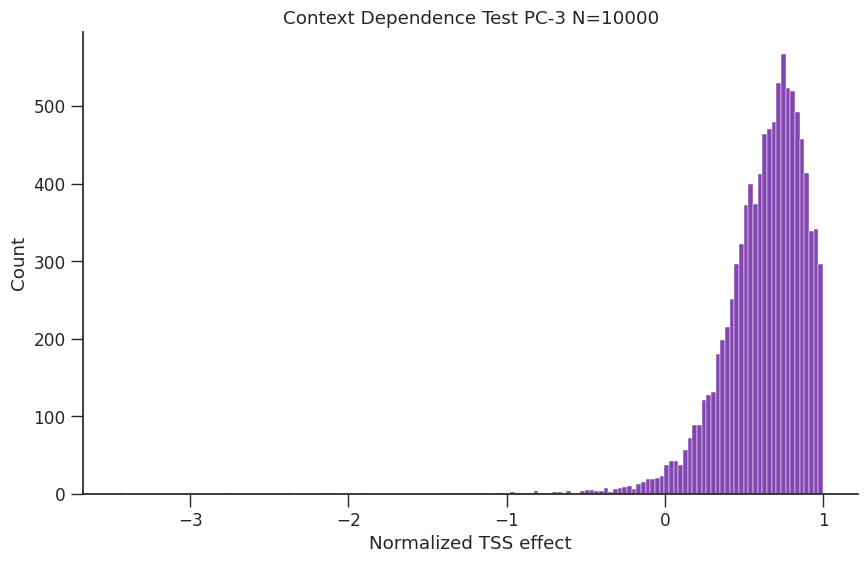

In [13]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in res.groupby('cell line'):
    
    fig = plt.figure(figsize=[10, 6])
    ax = sns.histplot(x=df['delta mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


(409, 9)
(183, 9)
(78, 9)
['enhancing (N=200)', 'neutral (N=183)', 'silencing (N=78)']
(482, 9)
(295, 9)
(318, 9)
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=200)']
(524, 9)
(110, 9)
(90, 9)
['enhancing (N=200)', 'neutral (N=110)', 'silencing (N=90)']


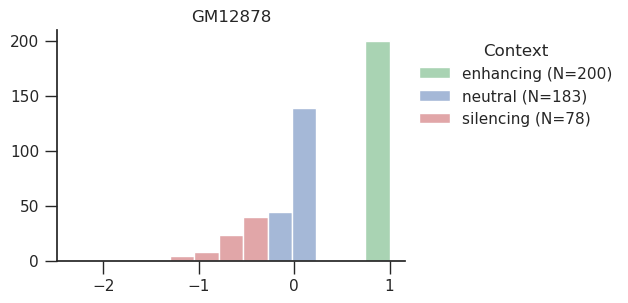

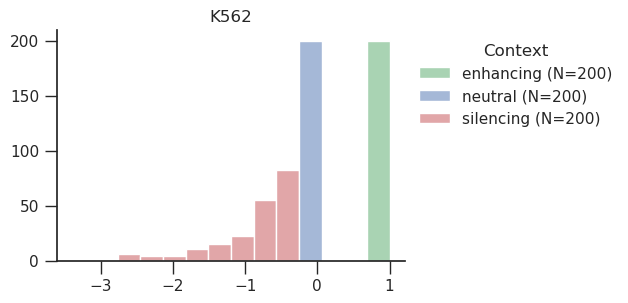

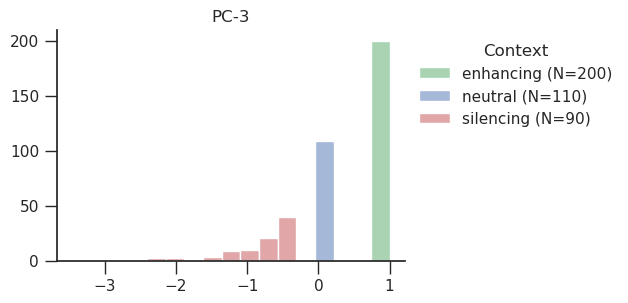

In [14]:
max_sample_size = 200
for k, df in res.groupby('cell line'):
    
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = df[(df['context']!='other') & (df['context']!='other1')]
    context_df_subsample = []
    for context_type, one_context_df in context_df.groupby('context'):
        print(one_context_df.shape)
        if one_context_df.shape[0] > max_sample_size:
            
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.concat(context_df_subsample)

    context_df = context_df.sort_values('context')
    ax = sns.histplot(data=context_df, 
                      x='delta mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)
    # plt.ylim(0,100)
    # plt.xlim([-2,1.1])
    # plt.yticks([0,50,100])
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')
    context_df.to_csv(f'../results/context_dependence_test/{model_name}/{k}_context.csv')


In [35]:
df

,delta mean,path,wt,context,cell line
0,0.510139,../results/context_dependence_test/enformer/XP...,14.783686,other,PC-3
1,0.939964,../results/context_dependence_test/enformer/UP...,14.785568,other,PC-3
2,0.874547,../results/context_dependence_test/enformer/PL...,14.797552,other,PC-3
3,-0.996532,../results/context_dependence_test/enformer/ZN...,14.800878,silencing,PC-3
4,0.847226,../results/context_dependence_test/enformer/SL...,14.805020,other,PC-3
...,...,...,...,...,...
9995,0.672157,../results/context_dependence_test/enformer/CC...,447.296265,other,PC-3
9996,0.704326,../results/context_dependence_test/enformer/MD...,449.297974,other,PC-3
9997,0.576422,../results/context_dependence_test/enformer/HS...,451.603577,other,PC-3
9998,0.553474,../results/context_dependence_test/enformer/IT...,454.687561,other,PC-3


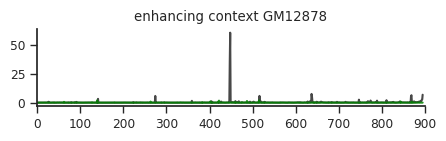

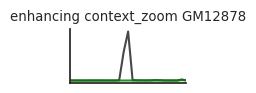

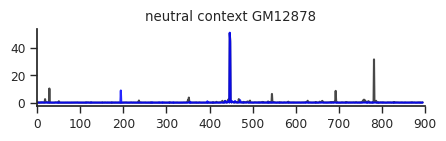

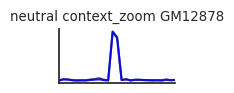

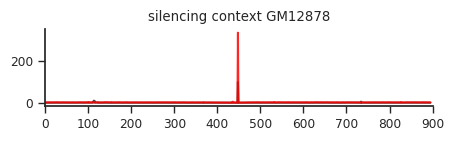

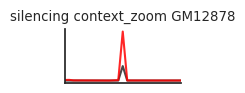

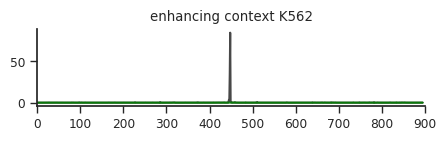

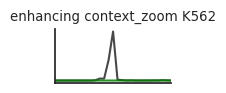

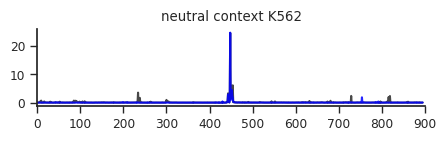

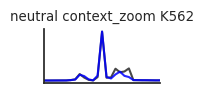

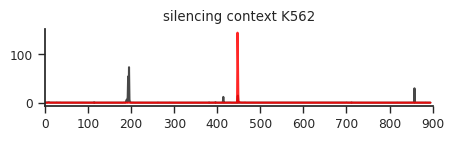

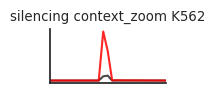

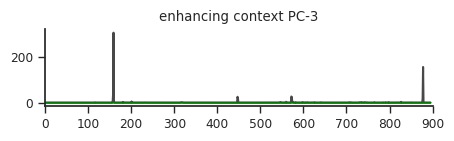

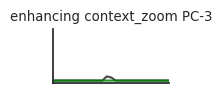

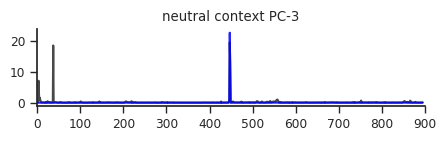

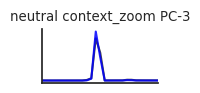

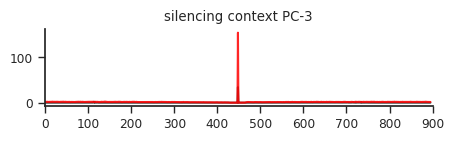

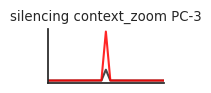

In [33]:
for k, df in res.groupby('cell line'):
    
    cell_pred_index = cell_line_names.index(k)

    # select most illustrative cases
    
    for name, color, selected_point in zip(['enhancing context', 'neutral context', 'silencing context'],
                                    ['green', 'blue', 'red'],
                                    [df[df['context']=='enhancing'].sort_values('delta mean')['path'].values[-1],
                                     df[df['context']=='neutral']['path'].values[0],
                                     df[df['context']=='silencing'].sort_values('delta mean')['path'].values[0]
                                     ]):
        with open(selected_point, 'rb') as handle:
            context_res = pickle.load(handle)
        wt = context_res['wt'][:, cell_pred_index]
        mut = context_res['mut'][:, cell_pred_index]
        for zoom in [None, [425, 475]]:
            if zoom:
                fig = plt.figure(figsize=[1.5, .7])
                name = name + '_zoom'
            else:
                fig = plt.figure(figsize=[5, 1])
                
            sns.set(font_scale = .8)
        
            sns.set_style(style='white')
            plt.rcParams['xtick.major.size'] = 5
            plt.rcParams['xtick.major.width'] = 1
        
            plt.rcParams['ytick.major.size'] = 5
            plt.rcParams['ytick.major.width'] = 1
            plt.rcParams['xtick.bottom'] = True
            plt.rcParams['ytick.left'] = True
        
            plt.plot(wt, 'k', alpha=0.8)
            plt.plot(mut, color=color, alpha=0.85)
            plt.xlim(0, 900)
            
            if zoom is None:
                if k == 'strong':
                    plt.ylabel('TSS activity')
                if k == 'repressing CRE':
                    plt.xlabel('Binned positions (128 nt)')
                    
            if zoom:
                sns.set(font_scale = .8)
                plt.xticks([])
                plt.yticks([])
                plt.xlim(435, 461)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.title(f'{name} {k}')
            plt.show()
            # fig.savefig(f'{pdf_dir}/{model_name}_{k}_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    #     break
    # break

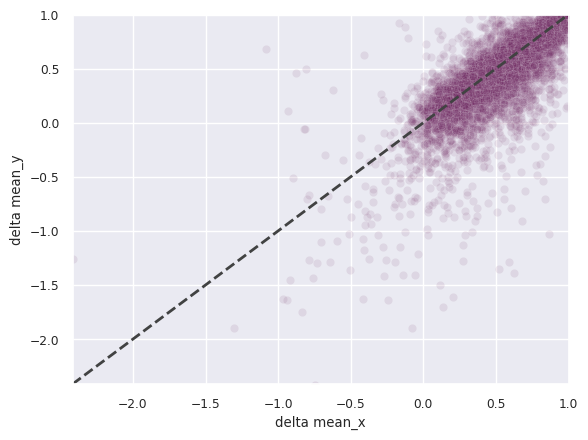

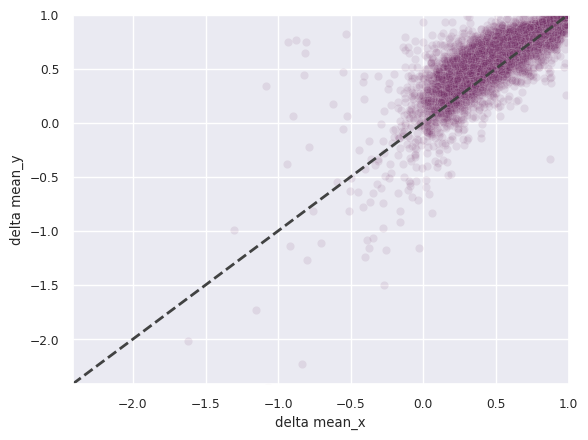

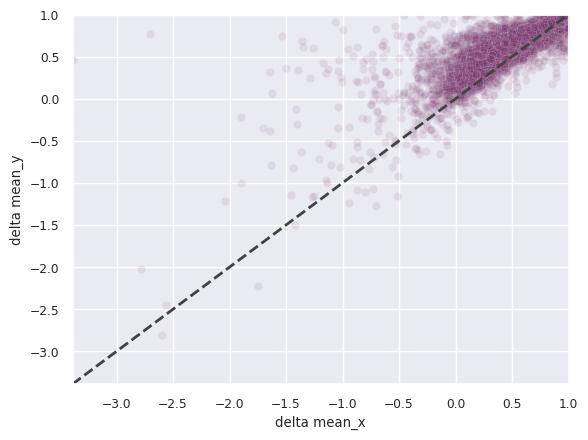

In [38]:
for df1, df2 in list(itertools.combinations([df for _, df  in res.groupby('cell line')], 2)):
    diff_comp = df1.merge(df2, on='path')
    sns.scatterplot(data=diff_comp, x='delta mean_x', y='delta mean_y', edgecolors=None, color='#702963', alpha=0.1)
    min_point = np.array(diff_comp['delta mean_x'], diff_comp['delta mean_y']).min()
    # add y=x line
    plt.plot([min_point,1],[min_point,1], lw=2, color='#414242', linestyle='dashed')
    # plt.xlabel(f'{c1} normalized TSS effect')
    # plt.ylabel(f'{c2} normalized TSS effect')
    plt.xlim(min_point,1)
    plt.ylim(min_point,1)
    plt.show()